# C4W3: Using RNNs to predict time series

* https-deeplearning-ai/**tensorflow-1-public**/C4/W3/assignment/[C4W3_Assignment.ipynb](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/assignment/C4W3_Assignment.ipynb)
* Commit `7ea55db` on Apr 18, 2022 - [Compare](https://github.com/https-deeplearning-ai/tensorflow-1-public/compare/7ea55db..)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

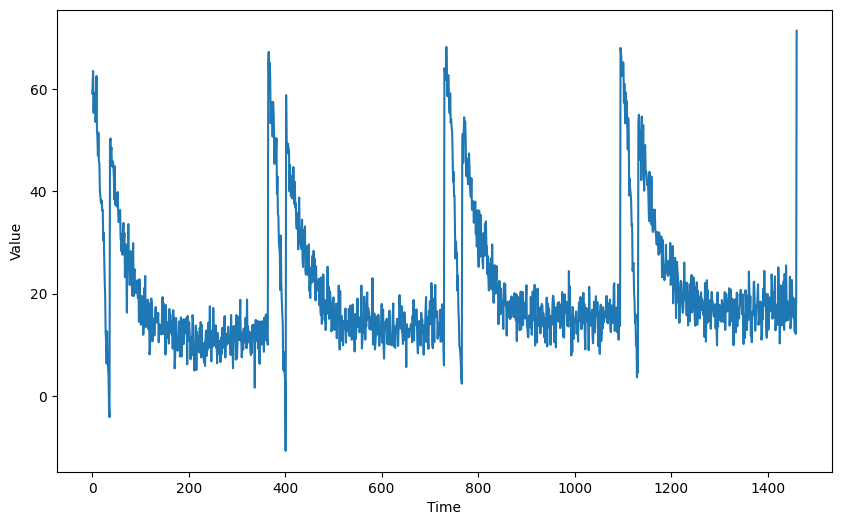

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(series_train)

## Defining the model architecture

In [6]:
def create_uncompiled_model():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[G.WINDOW_SIZE]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 

    return model

In [7]:
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

34/34 [==============================] - 2s 14ms/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate

In [8]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    optimizer = 'adam'

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [9]:
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 4s 16ms/step - loss: 47.3909 - mae: 47.8909 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 1s 15ms/step - loss: 44.8552 - mae: 45.3552 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 1s 16ms/step - loss: 42.0223 - mae: 42.5223 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 1s 14ms/step - loss: 38.8538 - mae: 39.3522 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 1s 14ms/step - loss: 35.4233 - mae: 35.9225 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 1s 13ms/step - loss: 31.7980 - mae: 32.2954 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 1s 13ms/step - loss: 28.1570 - mae: 28.6554 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 1s 14ms/step - loss: 24.6715 - mae: 25.1688 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 1s 13ms/step - loss: 21.5679 - mae:

(1e-06, 1.0, 0.0, 30.0)

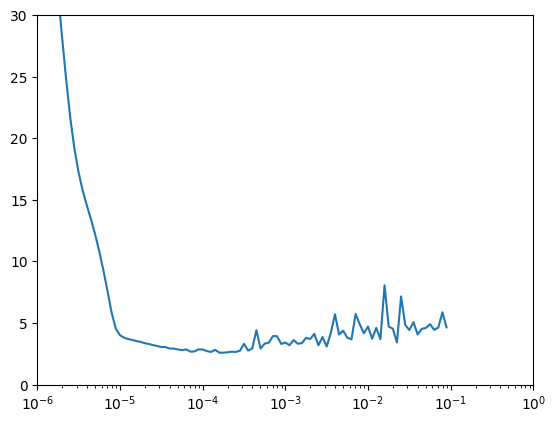

In [10]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

In [11]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    model.compile(optimizer='adam',
                  loss='huber',
                  metrics=["mae"])  
    
    return model

In [12]:
model = create_model()

history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 4s 17ms/step - loss: 9.2080 - mae: 9.6923
Epoch 2/50
34/34 [==============================] - 1s 18ms/step - loss: 3.1793 - mae: 3.6464
Epoch 3/50
34/34 [==============================] - 1s 17ms/step - loss: 3.3067 - mae: 3.7763
Epoch 4/50
34/34 [==============================] - 1s 15ms/step - loss: 3.1744 - mae: 3.6450
Epoch 5/50
34/34 [==============================] - 1s 14ms/step - loss: 3.3051 - mae: 3.7768
Epoch 6/50
34/34 [==============================] - 1s 13ms/step - loss: 3.0079 - mae: 3.4754
Epoch 7/50
34/34 [==============================] - 1s 14ms/step - loss: 2.7943 - mae: 3.2554
Epoch 8/50
34/34 [==============================] - 1s 13ms/step - loss: 3.5602 - mae: 4.0333
Epoch 9/50
34/34 [==============================] - 1s 13ms/step - loss: 3.1359 - mae: 3.6038
Epoch 10/50
34/34 [==============================] - 1s 13ms/step - loss: 2.8870 - mae: 3.3494
Epoch 11/50
34/34 [==============================] - 1s 13m

## Evaluating the forecast

In [13]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## Faster model forecasts

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 [==============================] - 1s 7ms/step


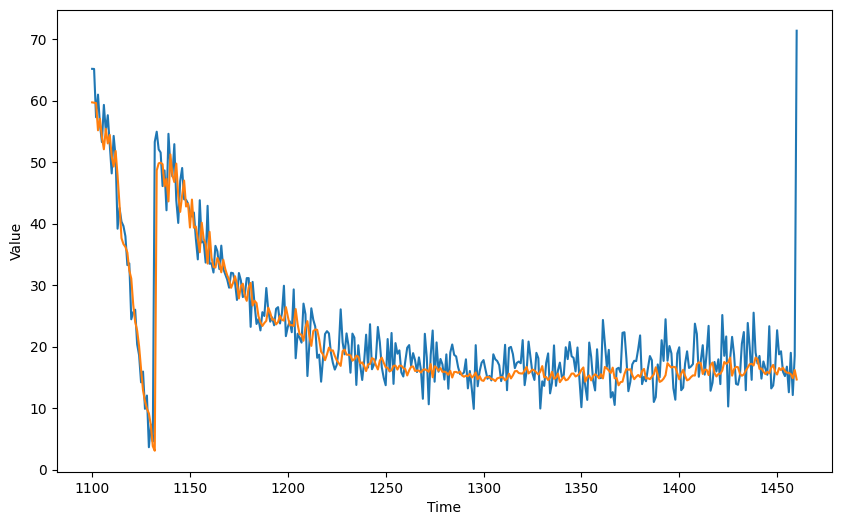

In [15]:
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 28.90, mae: 3.17 for forecast
